In [2]:
import pandas as pd
from models import base_res_net, small_res_net, efficient_net, pretrained_mobilenet, big_model, xception_net
import tensorflow as tf
import tensorflow.compat.v1 as tfc
from sklearn.utils.class_weight import compute_class_weight

import random
from modeling import predict, predict_from_csv, prob_predict, stack_predictions
from src import InputPipeline

%load_ext autoreload
%autoreload 2

## Check GPU for tf

In [3]:
# Some GPU setup
# for documentation about using gpus refer to: https://www.tensorflow.org/install/pip#windows-wsl2

tf.keras.backend.clear_session()

device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
try:  # prevent a previous session from being alive
  sess.close() 
except:
  pass

tfc.enable_eager_execution()
gpu_options= tfc.GPUOptions(per_process_gpu_memory_fraction = 0.80)
sess = tfc.InteractiveSession(config=tfc.ConfigProto(gpu_options=gpu_options))

### Optional Stuff
- Here we compute classweights since the data is very imbalanced

In [4]:
train_df = pd.read_csv("./data/train_images_stratified.csv")

In [5]:
class_weights = compute_class_weight(class_weight = 'balanced', classes = train_df["label"].unique(), y=train_df["label"])
class_weights = dict(enumerate(class_weights))

## Configure Parameters

In [60]:
#INPUT_SHAPE = (220,220,3)
INPUT_SHAPE = (220, 220,3)

CONF = {
  "learning_rate": 0.001,
  "batch_size": 32,
  "epochs": 50,
  "loss_function": "sparse_categorical_crossentropy",
  "metric": "sparse_categorical_accuracy",
}

## Make Input Pipelines

In [61]:
# Input pipeline for subspecies
sub_species_input_pipeline = InputPipeline(splits=(0.8,0.0,0.2), channels=3, batch_size=CONF["batch_size"], size=INPUT_SHAPE[:2])
# This has a stratified split
sub_species_input_pipeline.make_stratified_train_dataset(
  train_ds_path= "./data/train_ds_images_stratified.csv",
  val_ds_path="./data/val_ds_images_stratified.csv",
)


# Input pipeline for species
species_input_pipeline = InputPipeline(splits=(0.85,0.0,0.15), channels=3, batch_size=CONF["batch_size"], size=INPUT_SHAPE[:2])
species_input_pipeline.make_train_datasets(directory="./data/train_images/species_classify")  # This doesnt have a stratified split


Datasets populated!
Found 3926 files belonging to 70 classes.
Using 3338 files for training.
Using 588 files for validation.
Datasets populated!


## Training a Model

In [62]:
num_classes = 200

In [63]:
import tensorflow as tf
#from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.regularizers import l2, l1
from typing import Any, Callable
import tensorflow as tf
import pickle
import os

# base_model = keras.applications.Xception(include_top=False, 
#                                         weights="imagenet",
#                                         input_shape=INPUT_SHAPE,
#                                         pooling='max')

# base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False, 
#                                                                     weights="imagenet",
#                                                                     input_shape=INPUT_SHAPE,
#                                                                     pooling='max')

base_model = tf.keras.applications.NASNetMobile(include_top=False, 
                                                weights="imagenet",
                                                input_shape=INPUT_SHAPE,
                                                pooling='max',
                                              )
base_model.trainable = False

inputs = keras.Input(shape=INPUT_SHAPE)

x = keras.applications.nasnet.preprocess_input(inputs)

x = base_model(x, training=False)

x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = keras.layers.Dense(256, kernel_regularizer=l2(l=0.016), activity_regularizer=l1(0.006),
                        bias_regularizer=l1(0.006), activation='relu')(x)
x = keras.layers.Dropout(rate=0.45, seed=123)(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

subspecies_model = keras.Model(inputs, outputs)

In [64]:
callback_ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
callback_LR = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10)

subspecies_model.compile(
    loss=CONF["loss_function"],
    optimizer=keras.optimizers.Adam(CONF["learning_rate"]),
    metrics=CONF["metric"],
)

In [65]:
subspecies_model.summary(show_trainable=True)

Model: "model_8"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_20 (InputLayer)       [(None, 220, 220, 3)]     0         Y          
                                                                            
 tf.math.truediv_3 (TFOpLamb  (None, 220, 220, 3)      0         Y          
 da)                                                                        
                                                                            
 tf.math.subtract_3 (TFOpLam  (None, 220, 220, 3)      0         Y          
 bda)                                                                       
                                                                            
 NASNet (Functional)         (None, 1056)              4269716   N          
                                                                            
 batch_normalization_22 (Bat  (None, 1056)             4224

In [66]:
history_subspecies = subspecies_model.fit(
    sub_species_input_pipeline.train_dataset,
    epochs=CONF["epochs"],
    validation_data=sub_species_input_pipeline.validation_dataset,
    callbacks=[callback_ES, callback_LR],
    class_weight=class_weights
)

subspecies_model.save("./classifiers/NasNetMobile", overwrite=True, save_format="keras")

Epoch 1/50
99/99 [==============================] - 23s 131ms/step - loss: 12.2623 - sparse_categorical_accuracy: 0.1111 - val_loss: 9.1340 - val_sparse_categorical_accuracy: 0.2570
Epoch 2/50
99/99 [==============================] - 10s 97ms/step - loss: 8.2680 - sparse_categorical_accuracy: 0.3067 - val_loss: 7.0461 - val_sparse_categorical_accuracy: 0.2952
Epoch 3/50
99/99 [==============================] - 10s 97ms/step - loss: 6.5787 - sparse_categorical_accuracy: 0.3847 - val_loss: 5.8748 - val_sparse_categorical_accuracy: 0.3397
Epoch 4/50
99/99 [==============================] - 10s 97ms/step - loss: 5.3759 - sparse_categorical_accuracy: 0.4532 - val_loss: 5.1261 - val_sparse_categorical_accuracy: 0.3791
Epoch 5/50
99/99 [==============================] - 10s 97ms/step - loss: 4.7262 - sparse_categorical_accuracy: 0.4755 - val_loss: 4.6312 - val_sparse_categorical_accuracy: 0.3880
Epoch 6/50
99/99 [==============================] - 10s 98ms/step - loss: 4.2153 - sparse_categori

INFO:tensorflow:Assets written to: ./classifiers/NasNetMobile\assets


INFO:tensorflow:Assets written to: ./classifiers/NasNetMobile\assets


In [67]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
subspecies_model.summary(show_trainable=True)

subspecies_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=CONF["loss_function"],
    metrics=CONF["metric"],
)


Model: "model_8"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_20 (InputLayer)       [(None, 220, 220, 3)]     0         Y          
                                                                            
 tf.math.truediv_3 (TFOpLamb  (None, 220, 220, 3)      0         Y          
 da)                                                                        
                                                                            
 tf.math.subtract_3 (TFOpLam  (None, 220, 220, 3)      0         Y          
 bda)                                                                       
                                                                            
 NASNet (Functional)         (None, 1056)              4269716   Y          
                                                                            
 batch_normalization_22 (Bat  (None, 1056)             4224

In [68]:
epochs = 15
history_subspecies2 = subspecies_model.fit(
    sub_species_input_pipeline.train_dataset,
    epochs=epochs,
    validation_data=sub_species_input_pipeline.validation_dataset,
    callbacks=[callback_ES, callback_LR],
    class_weight=class_weights
)

subspecies_model.save("./classifiers/NasNetMobile", overwrite=True, save_format="keras")

Fitting the end-to-end model
Epoch 1/15
99/99 [==============================] - 55s 365ms/step - loss: 2.8282 - sparse_categorical_accuracy: 0.7051 - val_loss: 3.6873 - val_sparse_categorical_accuracy: 0.4440
Epoch 2/15
99/99 [==============================] - 36s 346ms/step - loss: 2.6909 - sparse_categorical_accuracy: 0.7475 - val_loss: 3.6305 - val_sparse_categorical_accuracy: 0.4606
Epoch 3/15
99/99 [==============================] - 36s 349ms/step - loss: 2.5712 - sparse_categorical_accuracy: 0.7783 - val_loss: 3.5976 - val_sparse_categorical_accuracy: 0.4618
Epoch 4/15
99/99 [==============================] - 32s 328ms/step - loss: 2.5242 - sparse_categorical_accuracy: 0.7828 - val_loss: 3.5678 - val_sparse_categorical_accuracy: 0.4707
Epoch 5/15
99/99 [==============================] - 36s 349ms/step - loss: 2.4659 - sparse_categorical_accuracy: 0.8022 - val_loss: 3.5507 - val_sparse_categorical_accuracy: 0.4860
Epoch 6/15
99/99 [==============================] - 40s 379ms/step

INFO:tensorflow:Assets written to: ./classifiers/NasNetMobile\assets


INFO:tensorflow:Assets written to: ./classifiers/NasNetMobile\assets


### SubSpecies Performance

In [ ]:
import matplotlib.pyplot as plt

history_subspecies = pd.DataFrame(history.history)
break_point = history_df.index.values.max()
history_subspecies2 = pd.DataFrame(history2.history)
history_subspecies2.set_index(pd.Index(range(break_point, break_point + len(history_df2))), inplace=True)
last_index = history_df2.index.values.max()

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(16,5))

# Plot for ax1
ax1.plot(history_subspecies["loss"], color='blue', label='Training Loss')
ax1.plot(history_subspecies2["loss"], color='blue')

ax1.plot(history_subspecies["val_loss"], color='red', label='Validation Loss')
ax1.plot(history_subspecies2["val_loss"], color='red')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.axvline(x=break_point, color='grey', linestyle='dashdot')

ax1.axvspan(0, break_point, facecolor='lightblue', alpha=0.2, label="Freezed Epochs")
ax1.axvspan(break_point, last_index, facecolor='red', alpha=0.1, label="Unfreezed Epochs")

ax1.set_xlim(left=0, right=last_index)
ax1.legend()


# Plot for ax2
ax2.plot(history_subspecies["sparse_categorical_accuracy"], color='blue', label='Training Accuracy')
ax2.plot(history_subspecies2["sparse_categorical_accuracy"], color='blue',)

ax2.plot(history_subspecies2["val_sparse_categorical_accuracy"], color='red', label='Validation Accuracy')
ax2.plot(history_subspecies["val_sparse_categorical_accuracy"], color='red')

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')


ax2.axvline(x=break_point, color='grey', linestyle='dashdot')

ax2.axvspan(0, break_point, facecolor='lightblue', alpha=0.2, label="Freezed Epochs")
ax2.axvspan(break_point, last_index, facecolor='red', alpha=0.1, label="Unfreezed Epochs")
ax2.legend()

ax2.annotate('Un-Freezed Network', xy=(10, max(ax1.get_ylim())), xytext=(15, max(ax1.get_ylim())),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)
ax2.set_xlim(left=0, right=last_index)

background_color = '#F8F1E2'  # Replace this with your hexadecimal color value
fig.patch.set_facecolor(background_color)

plt.show()

## Species Classifier

In [90]:
# base_model = keras.applications.Xception(include_top=False, 
#                                         weights="imagenet",
#                                         input_shape=INPUT_SHAPE,
#                                         pooling='max')

# base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False, 
#                                                                     weights="imagenet",
#                                                                     input_shape=INPUT_SHAPE,
#                                                                     pooling='max')

base_model = tf.keras.applications.NASNetMobile(include_top=False, 
                                                weights="imagenet",
                                                input_shape=INPUT_SHAPE,
                                                pooling='max',
                                              )
base_model.trainable = False

inputs = keras.Input(shape=INPUT_SHAPE)

x = keras.applications.nasnet.preprocess_input(inputs)

x = base_model(x, training=False)

x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = keras.layers.Dense(256, kernel_regularizer=l2(l=0.016), activity_regularizer=l1(0.006),
                        bias_regularizer=l1(0.006), activation='relu')(x)
x = keras.layers.Dropout(rate=0.45, seed=123)(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

species_model = keras.Model(inputs, outputs)

In [92]:
callback_ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
callback_LR = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=1)

species_model.compile(
    loss=CONF["loss_function"],
    optimizer=keras.optimizers.Adam(CONF["learning_rate"]),
    metrics=CONF["metric"],
)

In [93]:
species_model.summary(show_trainable=True)

Model: "model_11"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_26 (InputLayer)       [(None, 220, 220, 3)]     0         Y          
                                                                            
 tf.math.truediv_6 (TFOpLamb  (None, 220, 220, 3)      0         Y          
 da)                                                                        
                                                                            
 tf.math.subtract_6 (TFOpLam  (None, 220, 220, 3)      0         Y          
 bda)                                                                       
                                                                            
 NASNet (Functional)         (None, 1056)              4269716   N          
                                                                            
 batch_normalization_25 (Bat  (None, 1056)             422

In [94]:
history_species = species_model.fit(
    species_input_pipeline.train_dataset,
    epochs=CONF["epochs"],
    validation_data=species_input_pipeline.validation_dataset,
    callbacks=[callback_ES, callback_LR],
    class_weight=class_weights
)

species_model.save("./classifiers/Species_NasNetMobile", overwrite=True, save_format="keras")

Epoch 1/50
105/105 [==============================] - 27s 162ms/step - loss: 9.6204 - sparse_categorical_accuracy: 0.3212 - val_loss: 6.8747 - val_sparse_categorical_accuracy: 0.5153 - lr: 0.0010
Epoch 2/50
105/105 [==============================] - 13s 123ms/step - loss: 5.9754 - sparse_categorical_accuracy: 0.5282 - val_loss: 4.6671 - val_sparse_categorical_accuracy: 0.5799 - lr: 0.0010
Epoch 3/50
105/105 [==============================] - 13s 121ms/step - loss: 4.3939 - sparse_categorical_accuracy: 0.5899 - val_loss: 3.6432 - val_sparse_categorical_accuracy: 0.5867 - lr: 0.0010
Epoch 4/50
105/105 [==============================] - 13s 123ms/step - loss: 3.5426 - sparse_categorical_accuracy: 0.6306 - val_loss: 3.0973 - val_sparse_categorical_accuracy: 0.6003 - lr: 0.0010
Epoch 5/50
105/105 [==============================] - 13s 121ms/step - loss: 3.0623 - sparse_categorical_accuracy: 0.6528 - val_loss: 2.8566 - val_sparse_categorical_accuracy: 0.5884 - lr: 0.0010
Epoch 6/50
105/105 [

INFO:tensorflow:Assets written to: ./classifiers/Species_NasNetMobile\assets


INFO:tensorflow:Assets written to: ./classifiers/Species_NasNetMobile\assets


In [96]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
species_model.summary(show_trainable=True)

species_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=CONF["loss_function"],
    metrics=CONF["metric"],
)

Model: "model_11"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_26 (InputLayer)       [(None, 220, 220, 3)]     0         Y          
                                                                            
 tf.math.truediv_6 (TFOpLamb  (None, 220, 220, 3)      0         Y          
 da)                                                                        
                                                                            
 tf.math.subtract_6 (TFOpLam  (None, 220, 220, 3)      0         Y          
 bda)                                                                       
                                                                            
 NASNet (Functional)         (None, 1056)              4269716   Y          
                                                                            
 batch_normalization_25 (Bat  (None, 1056)             422

In [97]:
epochs = 15
history_species2 = species_model.fit(
    species_input_pipeline.train_dataset,
    epochs=epochs,
    validation_data=species_input_pipeline.validation_dataset,
    callbacks=[callback_ES, callback_LR],
    class_weight=class_weights
)

species_model.save("./classifiers/Species_NasNetMobile", overwrite=True, save_format="keras")

Epoch 1/15
105/105 [==============================] - 58s 375ms/step - loss: 1.3480 - sparse_categorical_accuracy: 0.9230 - val_loss: 1.8248 - val_sparse_categorical_accuracy: 0.6905 - lr: 1.0000e-05
Epoch 2/15
105/105 [==============================] - 36s 342ms/step - loss: 1.2756 - sparse_categorical_accuracy: 0.9410 - val_loss: 1.8052 - val_sparse_categorical_accuracy: 0.6837 - lr: 1.0000e-05
Epoch 3/15
105/105 [==============================] - 37s 343ms/step - loss: 1.2336 - sparse_categorical_accuracy: 0.9506 - val_loss: 1.7994 - val_sparse_categorical_accuracy: 0.6956 - lr: 1.0000e-05
Epoch 4/15
105/105 [==============================] - 37s 346ms/step - loss: 1.1727 - sparse_categorical_accuracy: 0.9632 - val_loss: 1.7831 - val_sparse_categorical_accuracy: 0.6905 - lr: 1.0000e-05
Epoch 5/15
105/105 [==============================] - 37s 344ms/step - loss: 1.1460 - sparse_categorical_accuracy: 0.9685 - val_loss: 1.7761 - val_sparse_categorical_accuracy: 0.6888 - lr: 1.0000e-05


INFO:tensorflow:Assets written to: ./classifiers/Species_NasNetMobile\assets


INFO:tensorflow:Assets written to: ./classifiers/Species_NasNetMobile\assets


### Species Performance

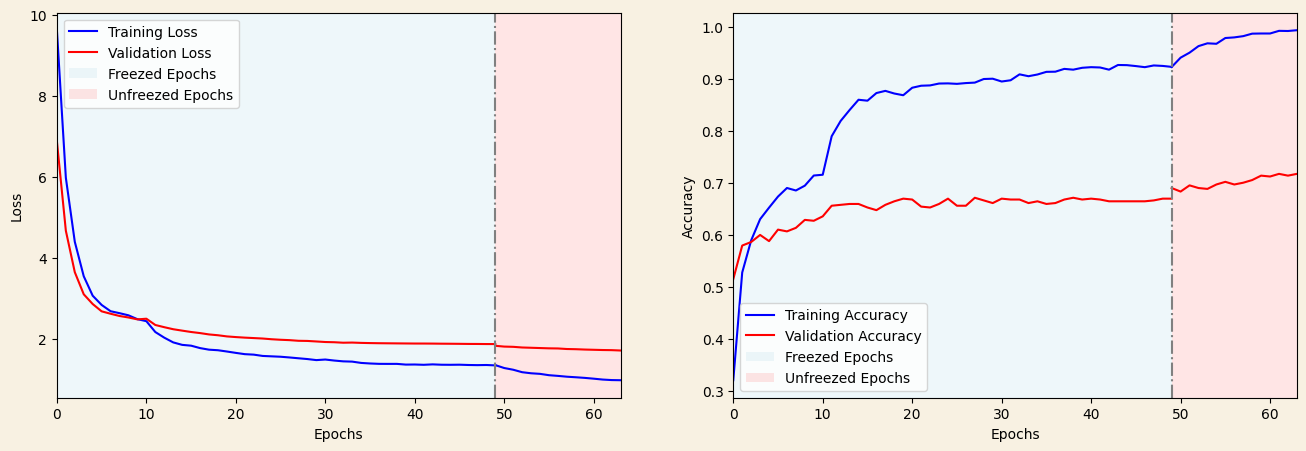

In [98]:
history_species_df = pd.DataFrame(history_species.history)
break_point = history_species_df.index.values.max()
history_species_df2 = pd.DataFrame(history_species2.history)
history_species_df2.set_index(pd.Index(range(break_point, break_point + len(history_species_df2))), inplace=True)
last_index = history_species_df2.index.values.max()

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(16,5))

# Plot for ax1
ax1.plot(history_species_df["loss"], color='blue', label='Training Loss')
ax1.plot(history_species_df2["loss"], color='blue')

ax1.plot(history_species_df["val_loss"], color='red', label='Validation Loss')
ax1.plot(history_species_df2["val_loss"], color='red')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.axvline(x=break_point, color='grey', linestyle='dashdot')

ax1.axvspan(0, break_point, facecolor='lightblue', alpha=0.2, label="Freezed Epochs")
ax1.axvspan(break_point, last_index, facecolor='red', alpha=0.1, label="Unfreezed Epochs")

ax1.set_xlim(left=0, right=last_index)
ax1.legend()


# Plot for ax2
ax2.plot(history_species_df["sparse_categorical_accuracy"], color='blue', label='Training Accuracy')
ax2.plot(history_species_df2["sparse_categorical_accuracy"], color='blue',)

ax2.plot(history_species_df2["val_sparse_categorical_accuracy"], color='red', label='Validation Accuracy')
ax2.plot(history_species_df["val_sparse_categorical_accuracy"], color='red')

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')


ax2.axvline(x=break_point, color='grey', linestyle='dashdot')

ax2.axvspan(0, break_point, facecolor='lightblue', alpha=0.2, label="Freezed Epochs")
ax2.axvspan(break_point, last_index, facecolor='red', alpha=0.1, label="Unfreezed Epochs")
ax2.legend()

ax2.annotate('Un-Freezed Network', xy=(10, max(ax1.get_ylim())), xytext=(15, max(ax1.get_ylim())),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)
ax2.set_xlim(left=0, right=last_index)

background_color = '#F8F1E2'  # Replace this with your hexadecimal color value
fig.patch.set_facecolor(background_color)

plt.show()

## Predict Directly to CSV

In [56]:
# # No label adjustments needed afterwards!!!!!!
# predict_from_csv(
#   subspecies_classifier="./classifiers/Species_NasNetMobile",
#   dataset="./data/test_images_path.csv",
#   path="./data/test_images",
#   size=INPUT_SHAPE,
# )

predicting: 100%|██████████| 4000/4000 [06:44<00:00,  9.90it/s]

Saving to: ./data/test_images_sample_1702027928.1660306.csv


## Predictions & Stacking Preds

In [99]:
species_preds = prob_predict(classifier="./classifiers/Species_NasNetMobile",
            dataset="./data/test_images_path.csv",
            path="./data/test_images",
            size=INPUT_SHAPE,
            )

predicting: 100%|██████████| 4000/4000 [08:22<00:00,  7.95it/s]


In [100]:
subspecies_preds = prob_predict(classifier="./classifiers/NasNetMobile",
            dataset="./data/test_images_path.csv",
            path="./data/test_images",
            size=INPUT_SHAPE,
            )

predicting: 100%|██████████| 4000/4000 [08:04<00:00,  8.26it/s]


In [101]:
species_preds.head()

,image_path,label,proba,max_prob,class_pred
id,,,,,
1,/test_images/999.jpg,1,"[[0.0001687635, 4.637815e-05, 0.00021055159, 5...",0.985403,28
2,/test_images/998.jpg,1,"[[0.00027531883, 1.8818648e-05, 0.00026956943,...",0.151353,64
3,/test_images/997.jpg,1,"[[0.00037646614, 0.0012525066, 0.00041174583, ...",0.733750,30
4,/test_images/996.jpg,1,"[[0.00033705664, 0.00035690432, 0.0019277438, ...",0.784430,4
5,/test_images/995.jpg,1,"[[4.161479e-05, 7.171708e-05, 2.9989305e-05, 6...",0.988750,30


In [102]:
subspecies_preds.head()

,image_path,label,proba,max_prob,class_pred
id,,,,,
1,/test_images/999.jpg,1,"[[6.7088513e-06, 3.757051e-05, 1.993007e-06, 4...",0.775250,67
2,/test_images/998.jpg,1,"[[0.00036134725, 3.8979953e-05, 0.00014621485,...",0.165551,99
3,/test_images/997.jpg,1,"[[6.6475272e-06, 2.6131325e-05, 0.0002844969, ...",0.354734,74
4,/test_images/996.jpg,1,"[[1.9961884e-05, 9.953262e-05, 1.2380226e-05, ...",0.900895,12
5,/test_images/995.jpg,1,"[[2.9805378e-05, 8.500873e-05, 0.0019973395, 0...",0.902898,74


In [103]:
result = stack_predictions(species_df = species_preds, subspecies_df = subspecies_preds, species_weight=(1), subspecies_weight=(0.3))

In [104]:
result[result["class_pred"]==result["combined_class_pred"]]

,image_path,label,proba,max_prob,class_pred,combined_class_pred
id,,,,,,
1,/test_images/999.jpg,1,"[[6.7088513e-06, 3.757051e-05, 1.993007e-06, 4...",0.775250,67,67
2,/test_images/998.jpg,1,"[[0.00036134725, 3.8979953e-05, 0.00014621485,...",0.165551,99,99
3,/test_images/997.jpg,1,"[[6.6475272e-06, 2.6131325e-05, 0.0002844969, ...",0.354734,74,74
4,/test_images/996.jpg,1,"[[1.9961884e-05, 9.953262e-05, 1.2380226e-05, ...",0.900895,12,12
5,/test_images/995.jpg,1,"[[2.9805378e-05, 8.500873e-05, 0.0019973395, 0...",0.902898,74,74
...,...,...,...,...,...,...
3994,/test_images/1003.jpg,1,"[[1.7605116e-05, 4.0784444e-06, 1.4982377e-05,...",0.540511,34,34
3996,/test_images/1001.jpg,1,"[[1.7211345e-07, 1.4122836e-05, 6.545828e-05, ...",0.219552,111,111
3997,/test_images/1000.jpg,1,"[[9.010284e-06, 0.00027781568, 8.894413e-06, 4...",0.344281,47,47


In [105]:
result["combined_class_pred"].to_csv("NASNetMobileSpecies_stacking.csv")

In [117]:
subspecies_preds[subspecies_preds["class_pred"]==1]

,image_path,label,proba,max_prob,class_pred
id,,,,,
285,/test_images/742.jpg,1,"[[0.3204486, 0.039502148, 0.26033399, 0.000274...",0.320449,1
794,/test_images/3885.jpg,1,"[[0.48375016, 0.09614499, 0.16358012, 0.000131...",0.483750,1
915,/test_images/3776.jpg,1,"[[0.39226627, 0.011977139, 0.21457316, 0.00027...",0.392266,1
963,/test_images/3732.jpg,1,"[[0.24592304, 0.083545335, 0.1757454, 0.000591...",0.245923,1
1291,/test_images/3437.jpg,1,"[[0.7236648, 0.0304744, 0.04711437, 0.00017170...",0.723665,1
1328,/test_images/3403.jpg,1,"[[0.4975887, 0.07420032, 0.08139341, 0.0002918...",0.497589,1
1427,/test_images/3314.jpg,1,"[[0.22566211, 0.0358477, 0.07124569, 0.0004680...",0.225662,1
1525,/test_images/3226.jpg,1,"[[0.31898704, 0.07669795, 0.07333878, 0.000625...",0.318987,1
1571,/test_images/3185.jpg,1,"[[0.21052243, 0.03149983, 0.114455014, 0.00111...",0.210522,1


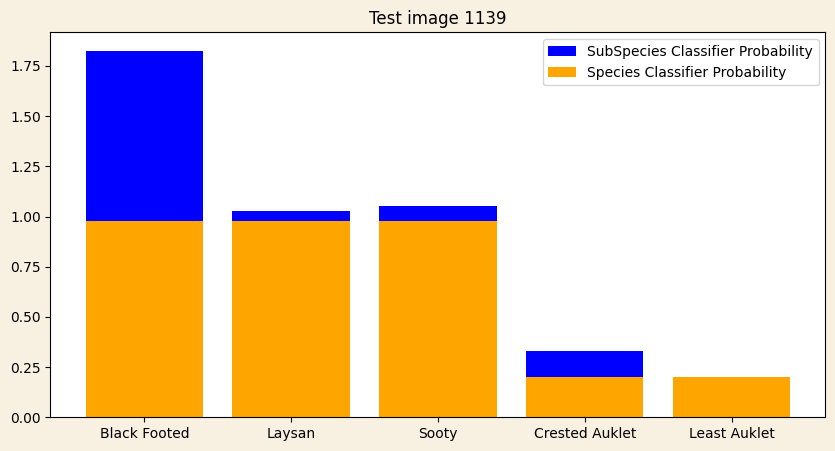

In [218]:
fig, ax1 = plt.subplots(1, figsize=(10,5))

species_prob_aux = species_preds[species_preds["image_path"]=="/test_images/1139.jpg"]["proba"].iloc[0][0][[0,2]]+[0,0.2]
subspecies_prob_aux = subspecies_preds[subspecies_preds["image_path"]=="/test_images/1139.jpg"]["proba"].iloc[0][0][[0,1,2,4,5]]+[species_prob[0],
                                                                                                                                      species_prob[0],
                                                                                                                                      species_prob[0],
                                                                                                                                      species_prob[1]+np.random.uniform(0.1, 0.4),
                                                                                                                                      species_prob[1]+np.random.uniform(0.1, 0.4),
                                                                                                                                      ]

ax1.bar(["Black Footed","Laysan","Sooty", 'Crested Auklet', 'Least Auklet'], 
        height=subspecies_prob_aux, 
        color="blue", label="SubSpecies Classifier Probability")
ax1.bar(["Black Footed","Laysan","Sooty",'Crested Auklet', 'Least Auklet'], 
        height=[species_prob_aux[0],
                species_prob_aux[0],
                species_prob_aux[0], 
                species_prob_aux[1], 
                species_prob_aux[1], 
                ],
        color="orange", label="Species Classifier Probability")
ax1.set_title("Test image 1139")
ax1.legend()
background_color = '#F8F1E2'  # Replace this with your hexadecimal color value
fig.patch.set_facecolor(background_color)
plt.show()